# 필수 라이브러리 연결

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array


# 이미지 불러오기

In [2]:
img_dir = 'drive/MyDrive/motorcycle/images'

In [3]:
import os

input_img_paths = []
target_img_paths = []

for fname in os.listdir(img_dir):
    if fname.endswith('__fuse.png'):
        target_img_paths.append(os.path.join(img_dir, fname))
    elif not fname.endswith('__save.png'):
        input_img_paths.append(os.path.join(img_dir, fname))

input_img_paths = sorted(input_img_paths)
target_img_paths = sorted(target_img_paths)
print(len(os.listdir(img_dir)))
print(len(input_img_paths))
print(len(target_img_paths))


600
200
200


input과 target에 200개씩 데이터가 들어있음을 확인

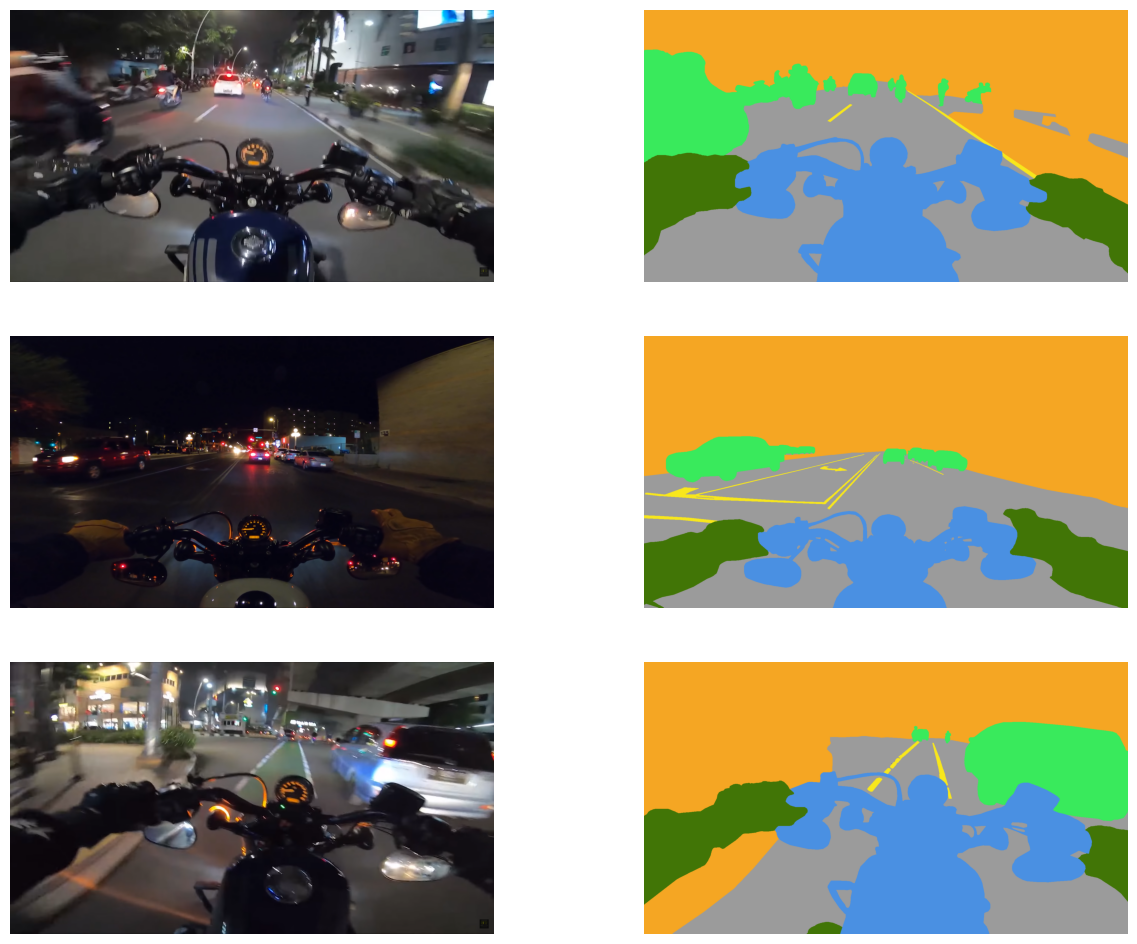

In [4]:
import random

plt.figure(figsize=(15, 12))
for i in range(3):
    idx = random.randint(0, 200)
    plt.subplot(3, 2, 2 * i + 1)
    plt.axis("off")
    plt.imshow(load_img(input_img_paths[idx]))
    plt.subplot(3, 2, 2 * i + 2)
    plt.axis("off")
    plt.imshow(load_img(target_img_paths[idx]))

위와 같이 인풋과 타겟 이미지의 쌍이 잘 paths에 매핑됨을 확인하였다.

In [5]:
input_img_arr = img_to_array(load_img(input_img_paths[0]))
target_img_arr = img_to_array(load_img(target_img_paths[0], color_mode='grayscale'))

print(input_img_arr.shape)
print(target_img_arr.shape)

(1080, 1920, 3)
(1080, 1920, 1)


1920 * 1080 크기의 3차원 텐서임을 확인함.

In [6]:
print(input_img_arr.min(), input_img_arr.max())
print(target_img_arr.min(), target_img_arr.max(), np.unique(target_img_arr))

0.0 255.0
89.0 213.0 [ 89. 132. 155. 165. 175. 213.]


input image의 경우 0~255 사이의 값을 가지는 것으로 확인

target imaget의 경우 특수한 숫자 값만을 가지는 것을 확인하였다.

In [7]:
target_img_arr = target_img_arr.astype("uint8")
target_map = {}
target_map_reverse = {}
for index, value in enumerate(np.unique(target_img_arr)):
    target_map[value] = index
    target_map_reverse[index] = value

print(target_map)
print(target_map_reverse)

{89: 0, 132: 1, 155: 2, 165: 3, 175: 4, 213: 5}
{0: 89, 1: 132, 2: 155, 3: 165, 4: 175, 5: 213}


이제 이미지 데이터셋을 불러옴.

In [9]:
img_size = (272, 480) # 추후에 u-net 계산을 편하게 하기 위해서 선택
num_imgs = len(input_img_paths)

random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target_image(path):
    img = img_to_array(load_img(path, color_mode="grayscale", target_size=img_size))
    img = img.astype("uint8")
    for key in target_map:
        img = np.where(img==key, target_map[key], img)
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
target_imgs = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    target_imgs[i] = path_to_target_image(target_img_paths[i])

num_val_samples = num_imgs // 10
num_test_samples = num_imgs // 10
train_input_imgs = input_imgs[:-num_val_samples-num_test_samples]
train_target_imgs = target_imgs[:-num_val_samples-num_test_samples]
val_input_imgs = input_imgs[-num_val_samples-num_test_samples:-num_test_samples]
val_target_imgs = target_imgs[-num_val_samples-num_test_samples:-num_test_samples]
test_input_imgs = input_imgs[-num_test_samples:]
test_target_imgs = target_imgs[-num_test_samples:]

print(train_input_imgs.shape)
print(train_target_imgs.shape)
print(val_input_imgs.shape)
print(val_target_imgs.shape)
print(test_input_imgs.shape)
print(test_target_imgs.shape)

(160, 272, 480, 3)
(160, 272, 480, 1)
(20, 272, 480, 3)
(20, 272, 480, 1)
(20, 272, 480, 3)
(20, 272, 480, 1)


In [10]:
train_target_imgs.min(), train_target_imgs.max(), np.unique(train_target_imgs)

(0, 5, array([0, 1, 2, 3, 4, 5], dtype=uint8))

train target image 값이 6개 클래스로 잘 들어가 있음을 확인

# 모델 구성하기

U-Net을 활용합니다. 기존 Unet과 인풋 이미지가 다른 픽셀을 가지고 있으므로 약간의 커스텀이 필요할 것 같습니다.

In [11]:
def get_model(img_size, num_classes, name="u-net"):
    inputs = layers.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    conv1 = layers.Conv2D(64, kernel_size=3, padding="same", activation='relu')(x)
    conv1 = layers.Conv2D(64, kernel_size=3, padding="same", activation='relu')(conv1)
    pool1 = layers.MaxPool2D()(conv1)

    conv2 = layers.Conv2D(128, kernel_size=3, padding="same", activation='relu')(pool1)
    conv2 = layers.Conv2D(128, kernel_size=3, padding="same", activation='relu')(conv2)
    pool2 = layers.MaxPool2D()(conv2)

    conv3 = layers.Conv2D(256, kernel_size=3, padding="same", activation='relu')(pool2)
    conv3 = layers.Conv2D(256, kernel_size=3, padding="same", activation='relu')(conv3)
    pool3 = layers.MaxPool2D()(conv3)

    conv4 = layers.Conv2D(512, kernel_size=3, padding="same", activation='relu')(pool3)
    conv4 = layers.Conv2D(512, kernel_size=3, padding="same", activation='relu')(conv4)
    pool4 = layers.MaxPool2D()(conv4)


    conv5 = layers.Conv2D(1024, kernel_size=3, padding="same", activation='relu')(pool4)
    conv5 = layers.Conv2D(1024, kernel_size=3, padding="same", activation='relu')(conv5)


    trans1 = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding="same", activation='relu')(conv5)
    concat1 = layers.concatenate([trans1, conv4], axis=-1)
    conv6 = layers.Conv2D(512, kernel_size=3, padding="same", activation='relu')(concat1)
    conv6 = layers.Conv2D(512, kernel_size=3, padding="same", activation='relu')(conv6)

    trans2 = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding="same", activation='relu')(conv6)
    concat2 = layers.concatenate([trans2, conv3], axis=-1)
    conv7 = layers.Conv2D(256, kernel_size=3, padding="same", activation='relu')(concat2)
    conv7 = layers.Conv2D(256, kernel_size=3, padding="same", activation='relu')(conv7)

    trans3 = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same", activation='relu')(conv7)
    concat3 = layers.concatenate([trans3, conv2], axis=-1)
    conv8 = layers.Conv2D(128, kernel_size=3, padding="same", activation='relu')(concat3)
    conv8 = layers.Conv2D(128, kernel_size=3, padding="same", activation='relu')(conv8)

    trans4 = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same", activation='relu')(conv8)
    concat4 = layers.concatenate([trans4, conv1], axis=-1)
    conv9 = layers.Conv2D(64, kernel_size=3, padding="same", activation='relu')(concat4)
    conv9 = layers.Conv2D(64, kernel_size=3, padding="same", activation='relu')(conv9)


    outputs = layers.Conv2D(num_classes, kernel_size=1)(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [12]:
model = get_model(img_size, 6)
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 272, 480, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 272, 480, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 272, 480, 64)         1792      ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 272, 480, 64)         36928     ['conv2d[0][0]']              
                                                                                              

input size와 output size가 같게 하는 모델을 만들었다. 이를 위해 img_size를 (272, 480)으로 선택하였다.

In [13]:
name="unet-base"
model = get_model(img_size, 6, name=name)

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("model_checkpoint_base-0.h5", save_best_only=True),
    # keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    keras.callbacks.TensorBoard(log_dir="./logs/" + name)
]

history = model.fit(train_input_imgs, train_target_imgs, batch_size=16, epochs=200,
                    validation_data=(val_input_imgs, val_target_imgs), callbacks=callbacks)


Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 2.4677 - accuracy: 0.2735

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 39s 900ms/step - loss: 2.4677 - accuracy: 0.2735 - val_loss: 1.6545 - val_accuracy: 0.3259
Epoch 2/200
10/10 [==============================] - 8s 805ms/step - loss: 1.6423 - accuracy: 0.3703 - val_loss: 1.5926 - val_accuracy: 0.4071
Epoch 3/200
10/10 [==============================] - 8s 830ms/step - loss: 1.5175 - accuracy: 0.4302 - val_loss: 1.4656 - val_accuracy: 0.4072
Epoch 4/200
10/10 [==============================] - 10s 1s/step - loss: 1.4330 - accuracy: 0.4302 - val_loss: 1.4099 - val_accuracy: 0.4072
Epoch 5/200
10/10 [==============================] - 6s 596ms/step - loss: 1.4087 - accuracy: 0.4302 - val_loss: 1.3884 - val_accuracy: 0.4072
Epoch 6/200
10/10 [==============================] - 7s 684ms/step - loss: 1.3919 - accuracy: 0.4302 - val_loss: 1.3678 - val_accuracy: 0.4072
Epoch 7/200
10/10 [==============================] - 6s 627ms/step - loss: 1.3543 - accuracy: 0.4302 - val_loss: 1.3214 - val_accuracy: 0.4074
Epoch 8/200


# 훈련 결과 살펴보기

In [14]:
def draw_history(history):
    epochs = range(1, len(history.history["loss"]) + 1)
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(epochs, loss, "bo", markersize=2, label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, accuracy, "bo", markersize=2, label="Training acc")
    plt.plot(epochs, val_accuracy, "b", label="Validation acc")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

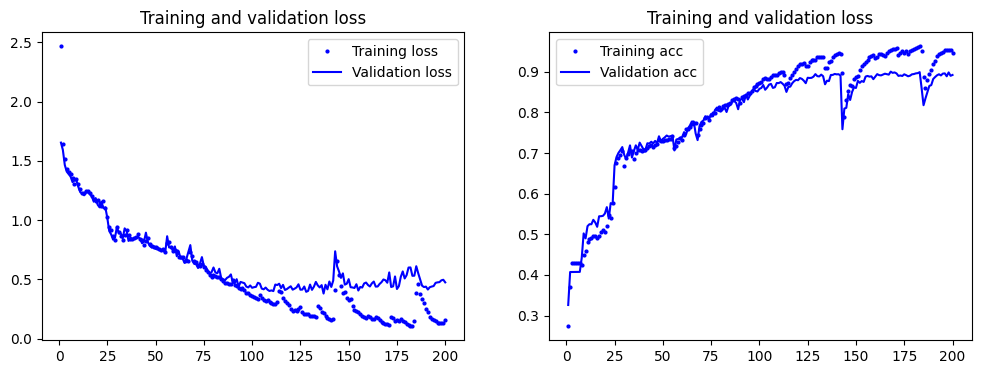

In [15]:
draw_history(history)

In [33]:
model = keras.models.load_model("model_checkpoint_base-0.h5")
model.evaluate(test_input_imgs, test_target_imgs)

1/1 [==============================] - 1s 775ms/step - loss: 0.4282 - accuracy: 0.8773


[0.4282325804233551, 0.877292811870575]

테스트 정확도에서 약 88프로정도의 정확도를 보였다.

또한 train 과정에서 loss를 찍어보았을때 약 90 epoch부터 과대적합이 시작됨을 확인할 수 있었다.

특이하게도 가끔 로스가 튀는 현상을 관찰할 수 있었다.

In [41]:
import cv2

def predict_to_mask(pred):
    mask = np.argmax(pred, axis=-1)
    # for key in target_map_reverse:
    #     mask = np.where(mask==key, target_map_reverse[key], mask)
    return mask

def create_mask(input):
    image = model.predict(np.expand_dims(test_input_imgs[idx], 0))[0]
    image = predict_to_mask(image)
    image = tf.expand_dims(image, -1)
    x1 = image.shape[0]
    x2 = image.shape[1]
    image = tf.reshape(tf.broadcast_to(image, (x1, x2, 3)),  (x1, x2, 3))
    return image


1/1 [==============================] - 0s 37ms/step


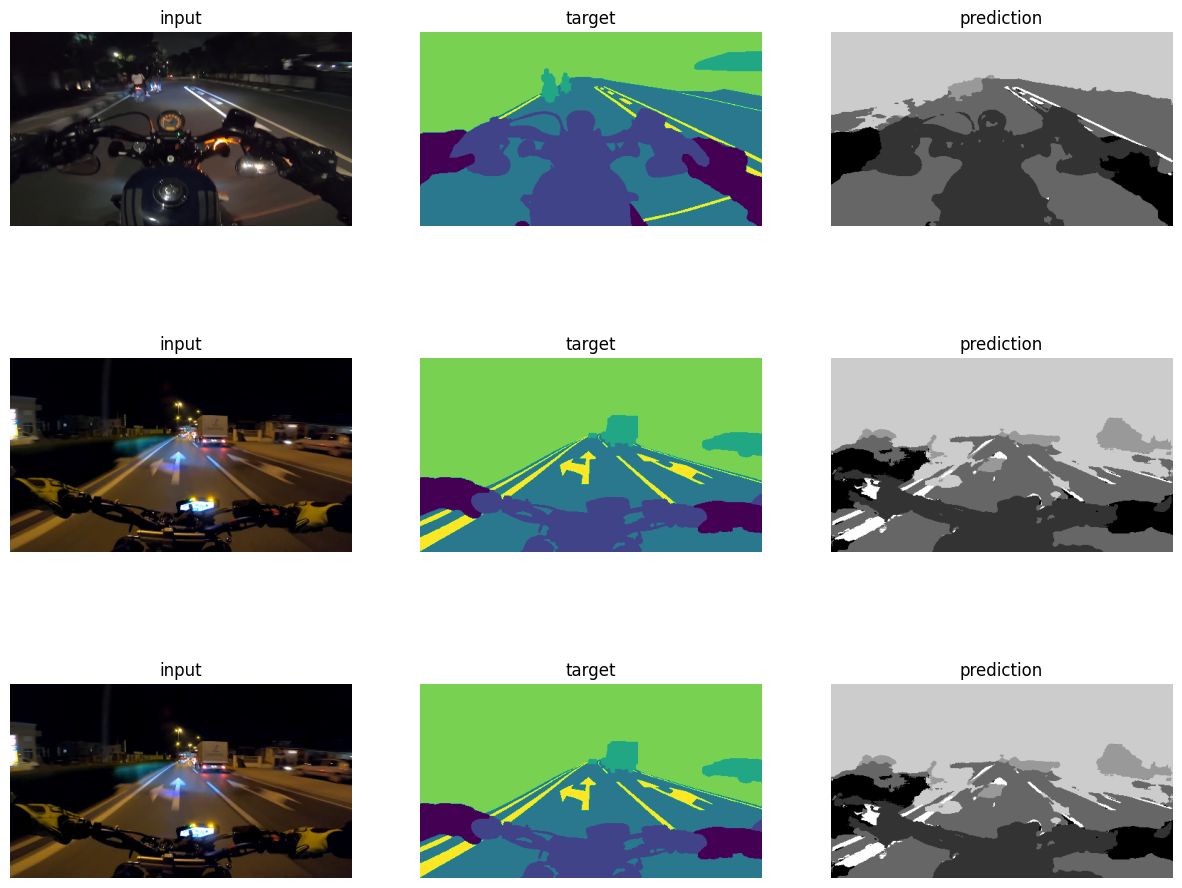

In [42]:
import random
from tensorflow.keras.utils import array_to_img

plt.figure(figsize=(15, 12))
for i in range(3):
    idx = random.randint(0, test_input_imgs.shape[0] - 1)
    plt.subplot(3, 3, 3 * i + 1)
    plt.axis("off")
    plt.imshow(array_to_img(test_input_imgs[idx]))
    plt.title("input")

    plt.subplot(3, 3, 3 * i + 2)
    plt.axis("off")
    plt.imshow(array_to_img(test_target_imgs[idx]))
    plt.title("target")

    plt.subplot(3, 3, 3 * i + 3)
    plt.axis("off")
    plt.imshow(array_to_img(create_mask(test_input_imgs[idx])))
    plt.title("prediction")


그래도 생각보다는 물체들이 인식이 되고 하는게 보이나 도로 면에 대해서는 표현이 좀 많이 사라진것 같다.

# 데이터 증강 기법 사용

전체적으로 데이터셋이 200개 밖에 없는 가난한 데이터셋이므로 증강을 이용해서 훈련을 더 일반화해보고자한다.

중요한 점중 하나는 input과 target이 함께 변경되어야한다는점이다.

In [347]:

def random_augment(input_image, target_image):
    # Random flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    # Random rotation
    # rotation_factor = tf.random.uniform((), minval=-0.1, maxval=0.1) * 360
    # input_image = ndimage.rotate(input_image, rotation_factor, reshape=False)
    # target_image = ndimage.rotate(target_image, rotation_factor, reshape=False)
    # target_image = tf.cast(target_image, tf.float32)
    # aug_image = tf.Variable(tf.concat([input_image, target_image], axis=-1))
    # augment = keras.Sequential([
    #     keras.layers.RandomFlip("horizontal"),
    #     keras.layers.RandomRotation(0.1),
    #     keras.layers.RandomZoom(0.2),
    # ])
    # aug_image = augment(aug_image)
    # aug_image = keras.layers.RandomFlip("horizontal")(aug_image)
    # aug_image = keras.layers.RandomRotation(0.1)(aug_image)
    # aug_image = keras.layers.RandomZoom(0.2)(aug_image)
    # input_image = aug_image[:,:,0:3]
    # target_image = aug_image[:,:,3:]

    # Random zoom
    zoom_factor = 10 + random.randint(-2, 3)
    input_image_shape = tf.shape(input_image)
    target_image_shape = tf.shape(target_image)

    input_image = tf.image.resize(input_image, (tf.cast(input_image_shape[0] * zoom_factor / 10, tf.int32),
                                                tf.cast(input_image_shape[1] * zoom_factor / 10, tf.int32)))
    target_image = tf.image.resize(target_image, (tf.cast(target_image_shape[0] * zoom_factor / 10, tf.int32),
                                                  tf.cast(target_image_shape[1] * zoom_factor / 10, tf.int32)))

    input_image = tf.image.resize_with_crop_or_pad(input_image, input_image_shape[0], input_image_shape[1])
    target_image = tf.image.resize_with_crop_or_pad(target_image, target_image_shape[0], target_image_shape[1])

    return input_image, tf.cast(target_image, "uint8")

(272, 480, 3) <dtype: 'float32'>
(272, 480, 1) <dtype: 'uint8'>


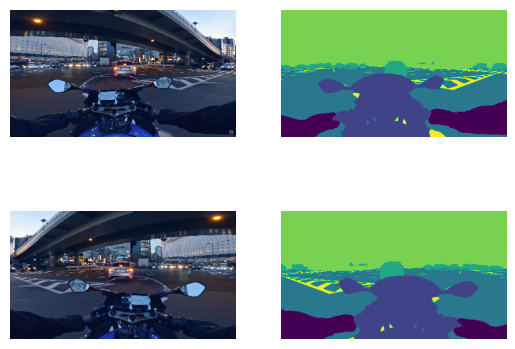

In [318]:
augment_test_input, augment_test_target = random_augment(test_input_imgs[0], test_target_imgs[0])

plt.subplot(221)
plt.axis("off")
plt.imshow(array_to_img(test_input_imgs[0]))
plt.subplot(222)
plt.axis("off")
plt.imshow(array_to_img(test_target_imgs[0]))
plt.subplot(223)
plt.axis("off")
plt.imshow(array_to_img(augment_test_input))
plt.subplot(224)
plt.axis("off")
plt.imshow(array_to_img(augment_test_target))

print(augment_test_input.shape, augment_test_input.dtype)
print(augment_test_target.shape, augment_test_target.dtype)

단일 이미지에 대해 augmentation이 잘 동작하는것 확인함

회전을 시도하다가 에러를 여기저기서 겪었는데, symbolic tensor가 numpy가 없다는 오류(구버전은 되는듯),

레이어를 넣어보려고했더니 ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.  이런 오류들이 나왔다.

씁쓸하다...

In [348]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_imgs, train_target_imgs))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input_imgs, val_target_imgs))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_imgs, test_target_imgs))

In [349]:
train_dataset = train_dataset.map(random_augment).batch(16).prefetch(tf.data.AUTOTUNE)

In [152]:
name="unet-augment"
model = get_model(img_size, 6, name=name)

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("model_checkpoint_augment-0.h5", save_best_only=True),
    # keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    keras.callbacks.TensorBoard(log_dir="./logs/" + name)
]

augment_history = model.fit(train_dataset, batch_size=16, epochs=200,
                    validation_data=(val_input_imgs, val_target_imgs), callbacks=callbacks)

Epoch 1/200
10/10 [==============================] - 12s 676ms/step - loss: 1.7582 - accuracy: 0.3501 - val_loss: 1.6192 - val_accuracy: 0.4072
Epoch 2/200
10/10 [==============================] - 7s 711ms/step - loss: 1.5484 - accuracy: 0.3835 - val_loss: 1.5622 - val_accuracy: 0.4069
Epoch 3/200
10/10 [==============================] - 6s 619ms/step - loss: 1.5148 - accuracy: 0.3843 - val_loss: 1.5245 - val_accuracy: 0.4694
Epoch 4/200
10/10 [==============================] - 5s 461ms/step - loss: 1.5018 - accuracy: 0.4105 - val_loss: 1.5350 - val_accuracy: 0.4985
Epoch 5/200
10/10 [==============================] - 6s 576ms/step - loss: 1.4838 - accuracy: 0.4464 - val_loss: 1.4803 - val_accuracy: 0.4780
Epoch 6/200
10/10 [==============================] - 10s 1s/step - loss: 1.4908 - accuracy: 0.4174 - val_loss: 1.4765 - val_accuracy: 0.4681
Epoch 7/200
10/10 [==============================] - 10s 1s/step - loss: 1.4757 - accuracy: 0.4119 - val_loss: 1.4619 - val_accuracy: 0.4781
Ep

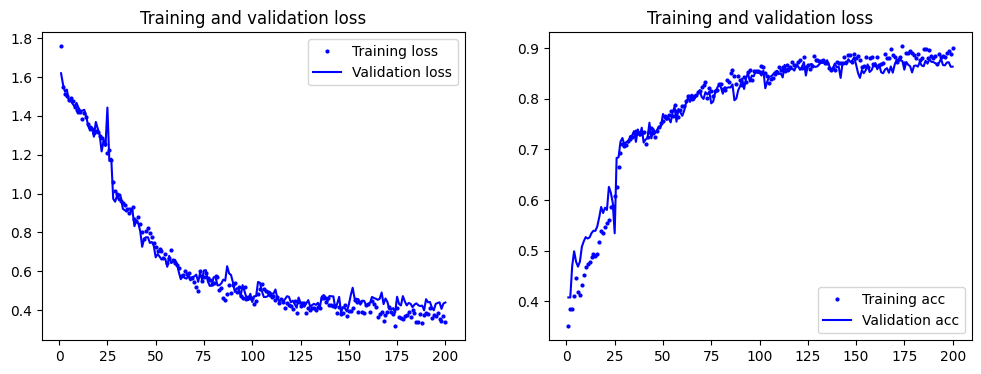

In [160]:
draw_history(augment_history)

In [161]:
model = keras.models.load_model("model_checkpoint_augment-0.h5")
model.evaluate(test_input_imgs, test_target_imgs)

1/1 [==============================] - 1s 563ms/step - loss: 0.3946 - accuracy: 0.8782


[0.394563227891922, 0.878188967704773]

1/1 [==============================] - 0s 21ms/step


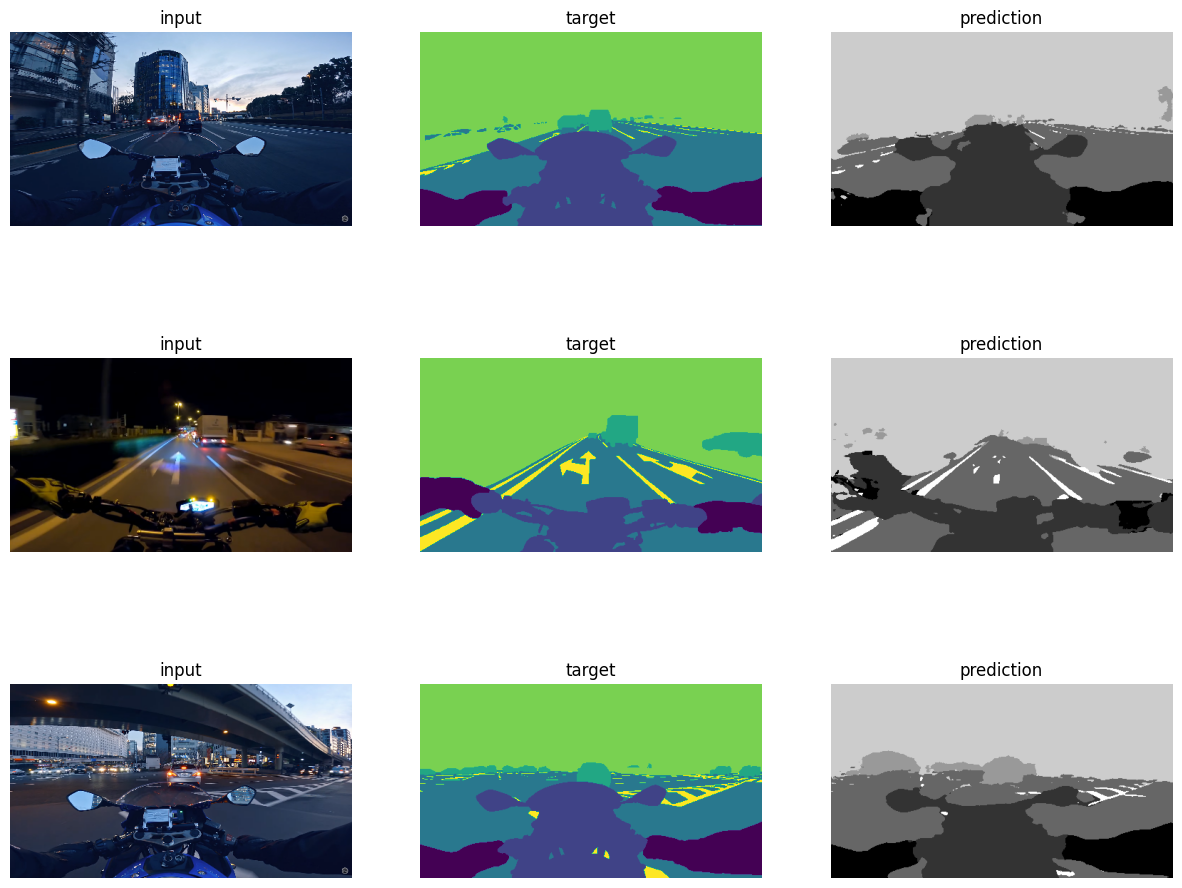

In [322]:
model = keras.models.load_model("model_checkpoint_augment-0.h5")
plt.figure(figsize=(15, 12))
for i in range(3):
    idx = random.randint(0, test_input_imgs.shape[0] - 1)
    plt.subplot(3, 3, 3 * i + 1)
    plt.axis("off")
    plt.imshow(array_to_img(test_input_imgs[idx]))
    plt.title("input")

    plt.subplot(3, 3, 3 * i + 2)
    plt.axis("off")
    plt.imshow(array_to_img(test_target_imgs[idx]))
    plt.title("target")

    plt.subplot(3, 3, 3 * i + 3)
    plt.axis("off")
    plt.imshow(array_to_img(create_mask(test_input_imgs[idx])))
    plt.title("prediction")

데이터 증강을 사용하니 loss가 살짝 줄었고, 정확도도 살짝 올라갔다.

90회쯤부터 나타나던 과적합 현상이 170회쯤부터서야 나타날듯 하기 시작하는 것처럼 느껴졌고 훨씬더 일반화를 긴 시간동안 진행했다는것을 볼수 있었다.

마지막 사진에서 투명 유리창부분이 도로로 인식된 부분이 이해가 되고 재밌엇던 부분인것 같다.

## zoom 비율 변경 테스트

In [321]:
name="unet-augment-2"
model = get_model(img_size, 6, name=name)

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("model_checkpoint_augment-2.h5", save_best_only=True),
    # keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    keras.callbacks.TensorBoard(log_dir="./logs/" + name)
]

augment_history2 = model.fit(train_dataset, batch_size=16, epochs=200,
                    validation_data=(val_input_imgs, val_target_imgs), callbacks=callbacks)

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 3.4270 - accuracy: 0.1859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 17s 1s/step - loss: 3.4270 - accuracy: 0.1859 - val_loss: 1.6593 - val_accuracy: 0.2162
Epoch 2/200
10/10 [==============================] - 9s 972ms/step - loss: 1.6155 - accuracy: 0.3533 - val_loss: 1.5863 - val_accuracy: 0.3936
Epoch 3/200
10/10 [==============================] - 7s 749ms/step - loss: 1.5636 - accuracy: 0.4270 - val_loss: 1.5221 - val_accuracy: 0.4082
Epoch 4/200
10/10 [==============================] - 10s 1s/step - loss: 1.4648 - accuracy: 0.4304 - val_loss: 1.4161 - val_accuracy: 0.4072
Epoch 5/200
10/10 [==============================] - 8s 834ms/step - loss: 1.4263 - accuracy: 0.4302 - val_loss: 1.4027 - val_accuracy: 0.4072
Epoch 6/200
10/10 [==============================] - 10s 1s/step - loss: 1.3899 - accuracy: 0.4302 - val_loss: 1.3743 - val_accuracy: 0.4072
Epoch 7/200
10/10 [==============================] - 10s 1s/step - loss: 1.3637 - accuracy: 0.4302 - val_loss: 1.3434 - val_accuracy: 0.4072
Epoch 8/200
10/10 [

In [323]:
model = keras.models.load_model("model_checkpoint_augment-2.h5")
model.evaluate(test_input_imgs, test_target_imgs)

1/1 [==============================] - 1s 557ms/step - loss: 0.3733 - accuracy: 0.8839


[0.373322457075119, 0.8839207887649536]

1/1 [==============================] - 0s 24ms/step


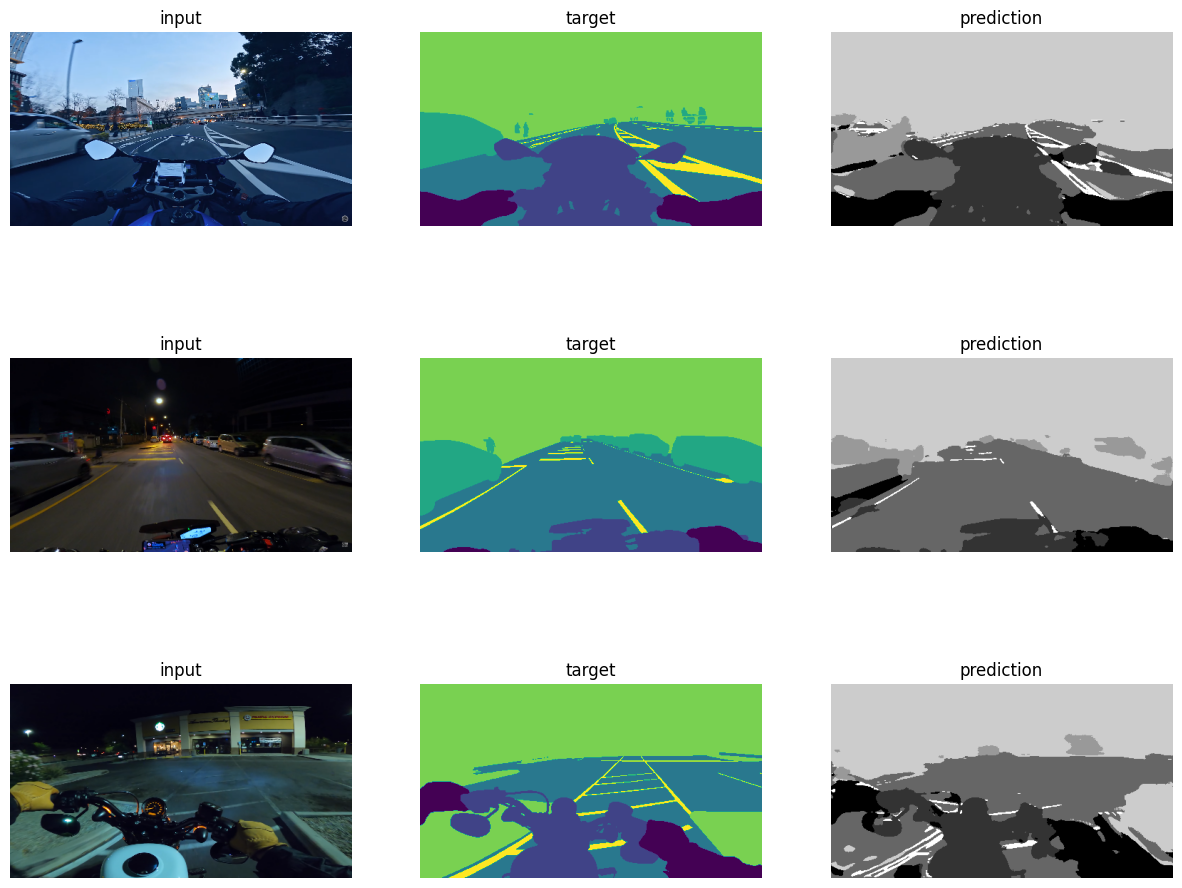

In [328]:
model = keras.models.load_model("model_checkpoint_augment-2.h5")
plt.figure(figsize=(15, 12))
for i in range(3):
    idx = random.randint(0, test_input_imgs.shape[0] - 1)
    plt.subplot(3, 3, 3 * i + 1)
    plt.axis("off")
    plt.imshow(array_to_img(test_input_imgs[idx]))
    plt.title("input")

    plt.subplot(3, 3, 3 * i + 2)
    plt.axis("off")
    plt.imshow(array_to_img(test_target_imgs[idx]))
    plt.title("target")

    plt.subplot(3, 3, 3 * i + 3)
    plt.axis("off")
    plt.imshow(array_to_img(create_mask(test_input_imgs[idx])))
    plt.title("prediction")

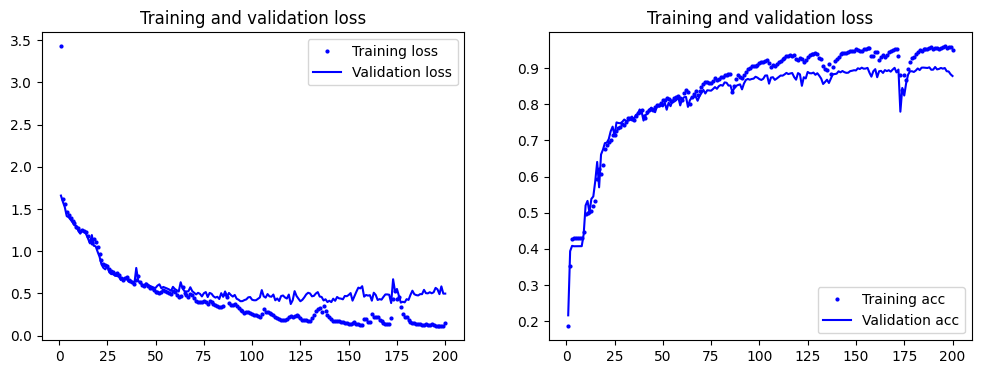

In [329]:
draw_history(augment_history2)

가장 좋은 모델이라고 해서 특별히 더 나은 모습을 보이는것 같지는 않다.

초기에 zoom 비율을 0.8 ~ 1.3에 두었어서 매우 늦게 과적합이 시작되었던 것과는 다르게 1.0 ~ 1.2 비율로 두었을때 살짝 좋은 결과가 나왔지만 그에비해 과적합은 75회 전후로 나타나는것 같다.

우연일수도 있겠지만... 아무래도 변화의 폭도 적고하니 이런 결과가 나온게 아닐까 싶기도하다.

또한 항상 그랬듯이 유넷을 훈련하다보면 꾸준히 loss가 크게 튀는 포인트가 찍히는것 같다.

# 텐서보드 허깅페이스 업로드

In [333]:
!tensorboard dev upload --logdir logs/unet-augment


2023-12-22 08:07:34.075912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 08:07:34.075978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 08:07:34.077765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 08:07:37.507321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [338]:
from huggingface_hub import push_to_hub_keras
model = keras.models.load_model("model_checkpoint_augment-0.h5")
push_to_hub_keras(model, "unet-augment")

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/82.2k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

saved_model.pb:   0%|          | 0.00/452k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/124M [00:00<?, ?B/s]

'https://huggingface.co/currybab/unet-augment/tree/main/'

In [339]:
! git lfs install
! git clone https://huggingface.co/currybab/unet-augment

# if you want to clone without large files – just their pointers
# prepend your git clone with the following env var:
! GIT_LFS_SKIP_SMUDGE=1

Git LFS initialized.
Cloning into 'unet-augment'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (14/14), 123.14 KiB | 4.56 MiB/s, done.


In [341]:
! mv logs/unet-augment/ unet-augment/logs/

In [346]:
!cd unet-augment/ && git add . && git config --global user.email "pj2417@gmail.com" && git config --global user.name "currybab" && git commit -m "unet-augment" && git push

[main 2ec6832] unet-augment
 6 files changed, 18 insertions(+)
 create mode 100644 logs/train/events.out.tfevents.1703224520.887c52e2b7e3.52866.2.v2
 create mode 100644 logs/train/events.out.tfevents.1703224666.887c52e2b7e3.52866.4.v2
 create mode 100644 logs/train/events.out.tfevents.1703224889.887c52e2b7e3.52866.6.v2
 create mode 100644 logs/validation/events.out.tfevents.1703224532.887c52e2b7e3.52866.3.v2
 create mode 100644 logs/validation/events.out.tfevents.1703224676.887c52e2b7e3.52866.5.v2
 create mode 100644 logs/validation/events.out.tfevents.1703224900.887c52e2b7e3.52866.7.v2
Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 2 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 1.32 KiB | 1.32 MiB/s, done.
Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/currybab/unet-augment
   a58b1ef..2ec6832  main -> main


https://huggingface.co/currybab/unet-augment/tensorboard 에서 확인 가능하다.

# 종합

데이터 증강기법중에 회전을 걸어보기위해 많은 삽질을 하였음에도 불구하고 결국 해내지 못한점이 아쉽다.

나중에 다시 도전해봐야지...

눈에 띄게 구별될 만큼 성능의 향상이 있진 않았어도 데이터 증강을 통해 일반화된 능력을 갖추는 것을 체크해볼 수 있어서 좋았다.
